In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

from scipy.sparse import csr_matrix, coo_matrix

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight, CosineRecommender, ItemItemRecommender

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

from lightgbm import LGBMClassifier

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import import_ipynb
from src.metrics import *
from src.utils import *
from src.recommenders import *

In [27]:
%%time

data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

Wall time: 3.99 s


In [28]:
data.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [29]:
item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


In [30]:
user_features.head(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


In [31]:
data.shape

(2396804, 12)

In [32]:
data.week_no.nunique()

95

### Preprocessing

In [33]:
def get_price(items, item_to_price):
    prices = []
    for item in items:
        price_item = item_to_price[item]
        prices.append(price_item)
    return prices   

In [34]:
data_price = data.groupby('item_id')[['quantity','sales_value']].sum().reset_index()
data_price['price'] = data_price['sales_value']/ (np.maximum(data_price['quantity'], 1))
item_id_price = data_price.item_id.values
price = data_price.price.values
item_to_price = dict(zip(item_id_price, price))
item_to_price[999999] = 0

In [35]:
%%time

val_lvl_1_size_weeks = 12
val_lvl_2_size_weeks = 6

data_train_lvl_1_2 = data[data['week_no'] < data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

Wall time: 805 ms


,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [36]:
%%time

item_id_before = data_train_lvl_1.item_id.nunique()
data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features)
item_id_after = data_train_lvl_1.item_id.nunique()

print('До фильтрации было {} товаров. После - {}'.format(item_id_before, item_id_after))

До фильтрации было 78727 товаров. После - 5001
Wall time: 8.55 s


### Baseline

In [37]:
%%time

recommender = MainRecommender(data_train_lvl_1)


Wall time: 8.12 s


In [42]:
def calculate_metrics(model, result_metrics, result, N=5, prefix=''):
    pred_funcs = {
        'get_als_recommendations':model.get_als_recommendations,
        'get_own_recommendations':model.get_own_recommendations,
        'get_similar_items_recommendation':model.get_similar_items_recommendation,
        'get_similar_users_recommendation':model.get_similar_users_recommendation,
        'get_i2i_recommendation': model.get_i2i_recommendation,
        'get_cosine_recommendation':model.get_cosine_recommendation
           }

    for pred_func in pred_funcs:
        pred_func_name = pred_func + prefix
        price_name = pred_func+'_price'
        result[pred_func] = result.user_id.apply(lambda x: pred_funcs[pred_func](x, N=N))
        result[price_name] = result.apply(lambda row: get_price(row.get(key=pred_func),item_to_price), axis=1)

        prec_at_k = result.apply(lambda row: precision_at_k(row.get(key=pred_func),row.get(key='actual')), axis=1).mean()
        money_prec_at_k = result.apply(lambda row: money_precision_at_k(row.get(key=pred_func),row.get(key='actual'), row.get(key=price_name)), axis=1).mean()
        rec_at_k = result.apply(lambda row: recall_at_k(row.get(key=pred_func),row.get(key='actual')), axis=1).mean()
        money_rec_at_k = result.apply(lambda row: money_recall_at_k(row.get(key=pred_func),row.get(key='actual'), row.get(key='actual_price')), axis=1).mean()

        result_metrics = result_metrics.append({
        'name':pred_func_name,
        'precision_at_k':prec_at_k,
        'money_precision_at_k':money_prec_at_k,
        'recall_at_k':rec_at_k,
        'money_recall_at_k':money_rec_at_k
        },ignore_index=True)

    
    return result_metrics

In [44]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2['actual_price'] = result_lvl_2.apply(lambda row: get_price(row.get(key='actual'),item_to_price), axis=1)
result_lvl_2.head(2)

,user_id,actual,actual_price
0,1,"[829323, 835108, 836423, 851515, 875240, 87737...","[2.7616451612903226, 1.94, 3.946176470588235, ..."
1,2,"[895388, 8357614, 12301772, 821083, 828106, 83...","[3.246, 3.373333333333333, 3.0, 1.531668508287..."


In [45]:
%%time

result_metrics = pd.DataFrame(columns=[
    'name',
    'precision_at_k',
    'money_precision_at_k',
    'recall_at_k', 
    'money_recall_at_k'])

result_metrics = calculate_metrics(recommender, result_metrics, result_lvl_2)

Wall time: 2min 38s


In [46]:
result_metrics

,name,precision_at_k,money_precision_at_k,recall_at_k,money_recall_at_k
0,get_als_recommendations,0.146017,0.143078,0.014675,0.020740
1,get_own_recommendations,0.162130,0.156972,0.014730,0.021621
2,get_similar_items_recommendation,0.081384,0.093434,0.007334,0.010407
3,get_similar_users_recommendation,0.004370,0.003526,0.000415,0.000395
4,get_i2i_recommendation,0.006919,0.006419,0.002333,0.002860
5,get_cosine_recommendation,0.007101,0.007220,0.000873,0.001448


### 2-х уровневая модель

In [47]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1['actual_price'] = result_lvl_1.apply(lambda row: get_price(row.get(key='actual'),item_to_price), axis=1)
result_lvl_1.head(2)

,user_id,actual,actual_price
0,1,"[888104, 913270, 995242, 1088462, 1124029, 557...","[4.990000000000001, 1.0701970443349753, 1.2125..."
1,2,"[825343, 826784, 833598, 858091, 885023, 88951...","[6.772787524366472, 1.321129943502825, 4.093, ..."


In [48]:
%%time

result_metrics = calculate_metrics(recommender, result_metrics, result_lvl_1, N=50, prefix='_cand50')

Wall time: 13min 5s


In [49]:
result_metrics

,name,precision_at_k,money_precision_at_k,recall_at_k,money_recall_at_k
0,get_als_recommendations,0.146017,0.143078,0.014675,0.020740
1,get_own_recommendations,0.162130,0.156972,0.014730,0.021621
2,get_similar_items_recommendation,0.081384,0.093434,0.007334,0.010407
3,get_similar_users_recommendation,0.004370,0.003526,0.000415,0.000395
4,get_i2i_recommendation,0.006919,0.006419,0.002333,0.002860
5,get_cosine_recommendation,0.007101,0.007220,0.000873,0.001448
6,get_als_recommendations_cand50,0.201991,0.198811,0.013732,0.019724
7,get_own_recommendations_cand50,0.219481,0.211983,0.013165,0.019646
8,get_similar_items_recommendation_cand50,0.114372,0.133950,0.007666,0.010597
9,get_similar_users_recommendation_cand50,0.005628,0.005173,0.000287,0.000400


In [50]:
def get_candidates(data_train_lvl_1, data_train_lvl_2, model, cand_type, client_type, N=50):
    users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
    users_lvl_2.columns = ['user_id']

    #Если client_type='warm', то предсказываем только для клиентов, которые совершили покупку в первом тренировочном множестве.
    train_users = data_train_lvl_1['user_id'].unique()
    if client_type=='warm':
        users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
    elif client_type=='cold':
        users_lvl_2 = users_lvl_2[~users_lvl_2['user_id'].isin(train_users)]
        
    #Предсказываем кандидатов
    if cand_type=='als':
        cand_model_name = 'candidates_' + cand_type
        users_lvl_2[cand_model_name] = users_lvl_2['user_id'].apply(lambda x: model.get_als_recommendations(x, N=N))
    elif cand_type=='own_rec':
        cand_model_name = 'candidates_' + cand_type
        users_lvl_2[cand_model_name] = users_lvl_2['user_id'].apply(lambda x: model.get_own_recommendations(x, N=N))
    
    #Преобразуем списки кандидатов в датафрейм user_id-item_id
    s = users_lvl_2.apply(lambda x: pd.Series(x[cand_model_name]), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'

    users_lvl_2 = users_lvl_2.drop(cand_model_name, axis=1).join(s)
    targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
    targets_lvl_2['target'] = 1  # тут только покупки 
    
    #Добавляем предсказанных кандидатов к второму тренировочному датасету
    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
    targets_lvl_2['target'].fillna(0, inplace= True)
    
    return targets_lvl_2, cand_model_name

In [51]:
targets_lvl_2, model_name = get_candidates(data_train_lvl_1, data_train_lvl_2, model=recommender, cand_type='als', client_type='warm')
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [52]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
#result_lvl_2['actual_price'] = result_lvl_2.apply(lambda row: get_price(row.get(key='actual'),item_to_price), axis=1)

In [53]:
def plotImp(model, X , fig_size = (40, 20)):
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    plt.savefig('lgbm_importances-01.png')

In [76]:
def get_precision_lvl_2(targets_lvl_2, result_lvl_2, model_name,feat_imp_graph=False):
    X_train = targets_lvl_2.drop('target', axis=1)
    y_train = targets_lvl_2[['target']]
    cat_feats = X_train.columns[2:15].tolist()
    X_train[cat_feats] = X_train[cat_feats].astype('category')

    lgb = LGBMClassifier(objective='binary', max_depth=50,num_iterations=100,learning_rate=0.3, categorical_column=cat_feats)
    lgb.fit(X_train, y_train)

    train_preds = lgb.predict_proba(X_train)
    X_train['target'] = train_preds[:,1]
    X_train.drop_duplicates(inplace=True)

    result = X_train.sort_values(by=['user_id','target'], ascending=[True, False])
    result = result.groupby('user_id').head(5).groupby('user_id').item_id.unique().reset_index(name=model_name)

    result = result_lvl_2.merge(result, on='user_id', how='left')
    prec_at_5 = result.apply(lambda row: precision_at_k(row.get(key=model_name),row.get(key='actual')), axis=1).mean()

    if feat_imp_graph:
        plotImp(lgb, X_train, fig_size = (40, 20))

    return prec_at_5


In [55]:
prec_at_5 = get_precision_lvl_2(targets_lvl_2, result_lvl_2, model_name)
print(prec_at_5*100)

C:\Users\Nikita\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Nikita\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Nikita\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


22.229601518026364


In [56]:
# for n in [40, 50 ,60, 100]:
#     for cand_type in ['als', 'own_rec']:
#         for client_type in ['warm', 'cold']:
#             target, model_name = get_candidates(data_train_lvl_1, data_train_lvl_2, model=recommender, cand_type=cand_type, client_type=client_type, N=n)
#             prec_at_5 = get_precision_lvl_2(target, result_lvl_2, model_name)
#             print("n={} cand_type={} client_type={} prec_at_5={}".format(n,cand_type,client_type, round(prec_at_5*100,2)))

### Feature engineering

In [57]:
data_train_lvl_2 = data_train_lvl_2.merge(item_features, on='item_id', how='left')
data_train_lvl_2 = data_train_lvl_2.merge(user_features, on='user_id', how='left')

##### Фичи юзеров

In [58]:
#Средний чек для каждого пользователя
avg_user_price = data_train_lvl_2.groupby('user_id').apply(lambda x: np.mean(x.sales_value*x.quantity)).reset_index(name='avg_price_user')
targets_lvl_2 = targets_lvl_2.merge(avg_user_price, on='user_id')

#Средняя цена одного купленного товара
avg_one_q = (data_train_lvl_2.groupby('user_id').apply(lambda x: x.sales_value.sum()/x.quantity.sum())).reset_index(name='avg_price_user_one_q')
targets_lvl_2 = targets_lvl_2.merge(avg_one_q, on='user_id')

#Средняя цена одной покупки (набора товаров)
avg_one_b = (data_train_lvl_2.groupby('user_id').apply(lambda x: x.sales_value.sum()/x.basket_id.nunique())).reset_index(name='avg_price_user_one_b')
targets_lvl_2 = targets_lvl_2.merge(avg_one_b, on='user_id')

#Число купленных товаров
sum_user_q = data_train_lvl_2.groupby('user_id').quantity.sum().reset_index(name='sum_user_q')
targets_lvl_2 = targets_lvl_2.merge(sum_user_q, on='user_id')

#Среднее количество дней между покупками
day_mean = (data_train_lvl_2.groupby('user_id').week_no.unique().apply(lambda x: (np.sum(x[1:])-np.sum(x[:-1]))/(len(x)-1))).reset_index(name='day_mean')
targets_lvl_2 = targets_lvl_2.merge(day_mean, on='user_id')

#Количество уникальных покупок юзеров по категориям
department_count = data_train_lvl_2.groupby(['user_id','department']).item_id.nunique().reset_index(name='dep_user_count')
targets_lvl_2 = targets_lvl_2.merge(department_count, on=['user_id','department'])

#Доля покупок со скидкой. Скидкой считаю, если цена за продукт минимальна и уникальных цен по товару >1.
min_price = data_train_lvl_2.groupby('item_id')['sales_value'].agg(min_price=np.min, un_count=lambda x: x.nunique()).reset_index()
data_train_lvl_2_with_min_price = data_train_lvl_2.merge(min_price, on='item_id',how='left')
data_train_lvl_2_with_min_price['if_sale'] = np.where((data_train_lvl_2_with_min_price.sales_value==data_train_lvl_2_with_min_price.min_price)&(data_train_lvl_2_with_min_price.un_count>1),1,0)
data_train_lvl_2_with_min_price = data_train_lvl_2_with_min_price.groupby('user_id').if_sale.sum()/data_train_lvl_2_with_min_price.groupby('user_id').if_sale.count()
data_train_lvl_2_with_min_price = data_train_lvl_2_with_min_price.reset_index(name='sale')
targets_lvl_2 = targets_lvl_2.merge(data_train_lvl_2_with_min_price, on='user_id')

#mean / max / std кол-ва уникальных товаров в корзине клиента
un_pr_b = data_train_lvl_2.groupby(['user_id','basket_id']).item_id.nunique().reset_index()\
    .groupby('user_id').item_id.agg(mean_p=np.mean, max_p=np.max, std_p=np.std)
targets_lvl_2 = targets_lvl_2.merge(un_pr_b, on='user_id')

#mean / max / std кол-ва уникальных категорий в корзине клиента
un_pr_d = data_train_lvl_2.groupby(['user_id','basket_id']).department.nunique().reset_index()\
    .groupby('user_id').department.agg(mean_d=np.mean, max_d=np.max, std_d=np.std).reset_index()
targets_lvl_2 = targets_lvl_2.merge(un_pr_d, on='user_id')

##### Фичи товаров

In [59]:
# Цена товара
price = data_train_lvl_2.groupby('item_id').sales_value.mean().reset_index(name='price')
targets_lvl_2 = targets_lvl_2.merge(price, on='item_id')

#Количество магазинов, в которых продается товар
shop_count=data_train_lvl_2.groupby('item_id').store_id.nunique().reset_index(name='shop_count')
targets_lvl_2 = targets_lvl_2.merge(shop_count, on='item_id')

#Кол-во покупок каждого товара в неделю
avg_q_per_week = (data_train_lvl_2.groupby('item_id').quantity.sum() / data_train_lvl_2.week_no.nunique()).reset_index(name='avg_q_per_week')
targets_lvl_2 = targets_lvl_2.merge(avg_q_per_week, on='item_id')

#Среднее кол-во покупок каждой категории товара в неделю
avg_d_q_per_week = (data_train_lvl_2.groupby('department').quantity.sum() / data_train_lvl_2.week_no.nunique()).reset_index(name='avg_d_q_per_week')
targets_lvl_2 = targets_lvl_2.merge(avg_d_q_per_week, on='department')

#Средняя сумма покупок каждой категории товара в неделю
avg_d_p_per_week = (data_train_lvl_2.groupby('department').sales_value.sum() / data_train_lvl_2.week_no.nunique()).reset_index(name='avg_d_p_per_week')
targets_lvl_2 = targets_lvl_2.merge(avg_d_p_per_week, on='department')

#Средняя сумма покупки товара в категории
dep_avg_price = data_train_lvl_2.groupby('department').sales_value.mean().reset_index(name='dep_avg_price')
targets_lvl_2 = targets_lvl_2.merge(dep_avg_price, on='department')

#Кол-во покупок юзером конкретной категории в неделю
d_cnt_week =data_train_lvl_2.groupby(['item_id','department']).quantity.sum().reset_index(name='d_cnt_week')
targets_lvl_2 = targets_lvl_2.merge(d_cnt_week, on=['item_id','department'])

##### Фичи пар user-item

In [60]:
#(Кол-во покупок в неделю) / (Среднее кол-во покупок 1 товара в категории в неделю)
targets_lvl_2['f1']= targets_lvl_2['avg_q_per_week']/ targets_lvl_2['avg_d_q_per_week']

#(Кол-во покупок в неделю) - (Среднее кол-во покупок 1 товара в категории в неделю)
targets_lvl_2['f3']= targets_lvl_2['avg_q_per_week']-targets_lvl_2['avg_d_q_per_week']

#Средняя сумма покупки товара в категории / Цена
targets_lvl_2['f3']= targets_lvl_2['avg_d_p_per_week']/targets_lvl_2['price']

#Средняя сумма покупки товара в категории - Цена
targets_lvl_2['f4']= targets_lvl_2['avg_d_p_per_week']-targets_lvl_2['price']

#Кол-во покупок юзером конкретной категории в неделю / Среднее кол-во покупок всеми юзерами конкретной категории в неделю
targets_lvl_2['f5']= targets_lvl_2['d_cnt_week']/targets_lvl_2['avg_d_q_per_week']

#Кол-во покупок юзером конкретной категории в неделю - Среднее кол-во покупок всеми юзерами конкретной категории в неделю
targets_lvl_2['f6']= targets_lvl_2['d_cnt_week']/targets_lvl_2['avg_d_q_per_week']

In [61]:
targets_lvl_2.columns

Index(['user_id', 'item_id', 'target', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
       'avg_price_user', 'avg_price_user_one_q', 'avg_price_user_one_b',
       'sum_user_q', 'day_mean', 'dep_user_count', 'sale', 'mean_p', 'max_p',
       'std_p', 'mean_d', 'max_d', 'std_d', 'price', 'shop_count',
       'avg_q_per_week', 'avg_d_q_per_week', 'avg_d_p_per_week',
       'dep_avg_price', 'd_cnt_week', 'f1', 'f3', 'f4', 'f5', 'f6'],
      dtype='object')

C:\Users\Nikita\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Nikita\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Nikita\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


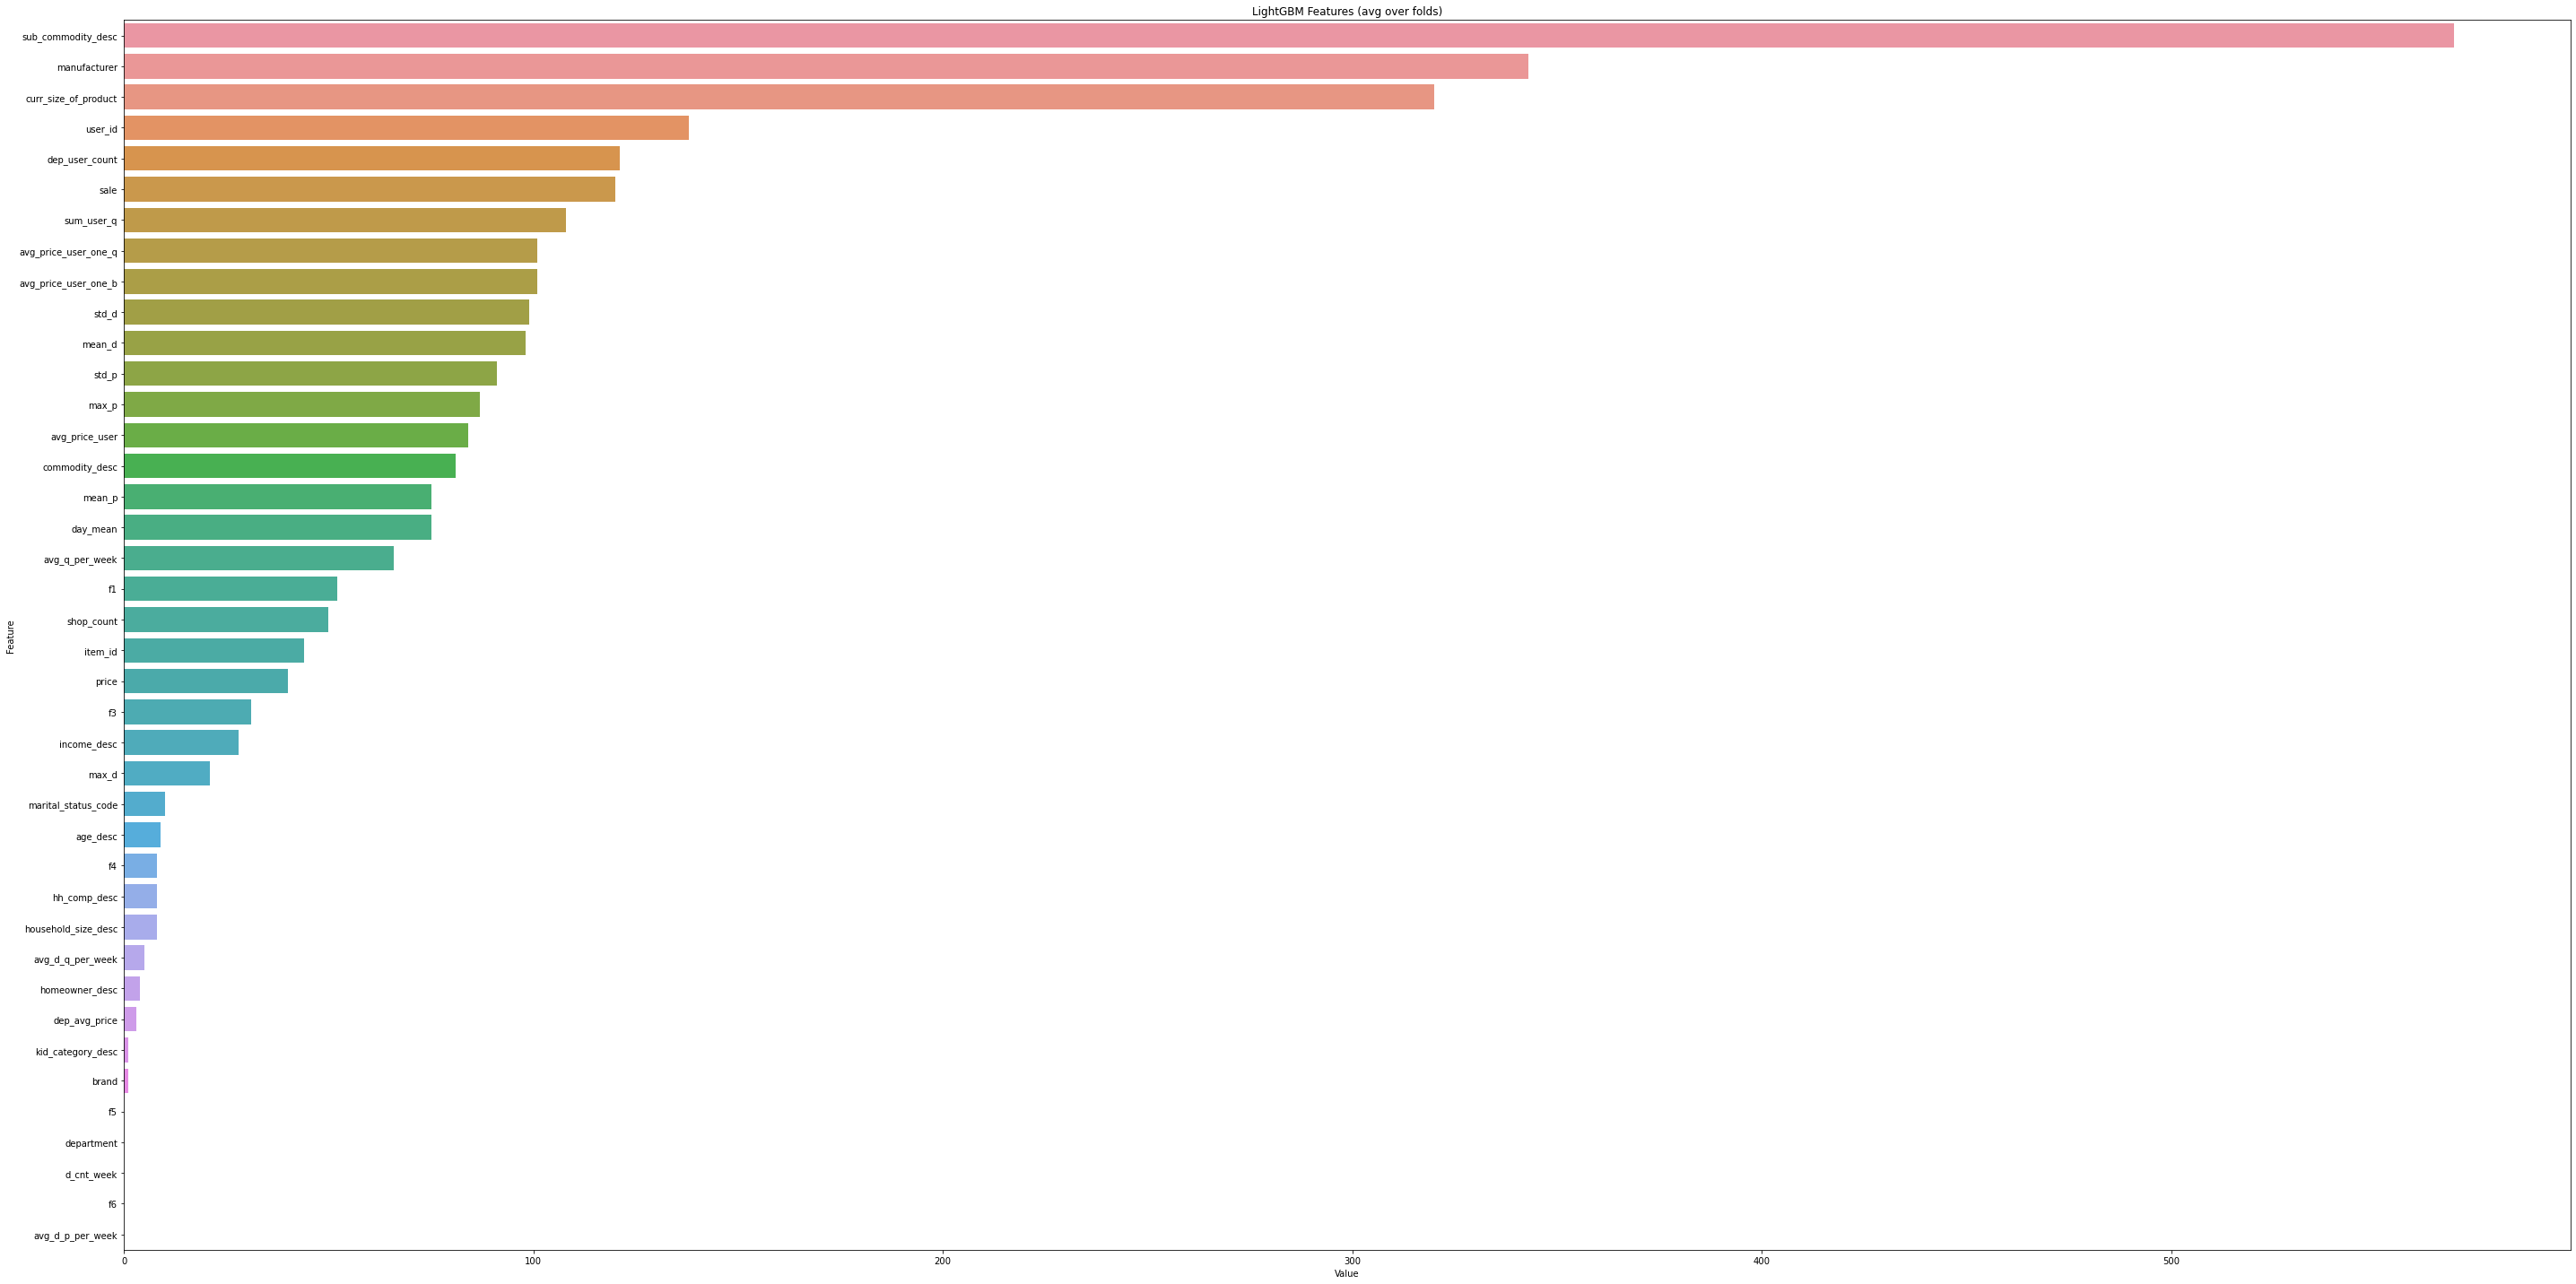

26.706330318895645


<Figure size 432x288 with 0 Axes>

In [77]:
prec_at_5 = get_precision_lvl_2(targets_lvl_2, result_lvl_2, model_name, feat_imp_graph=True)
print(prec_at_5*100)

C:\Users\Nikita\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Nikita\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Nikita\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


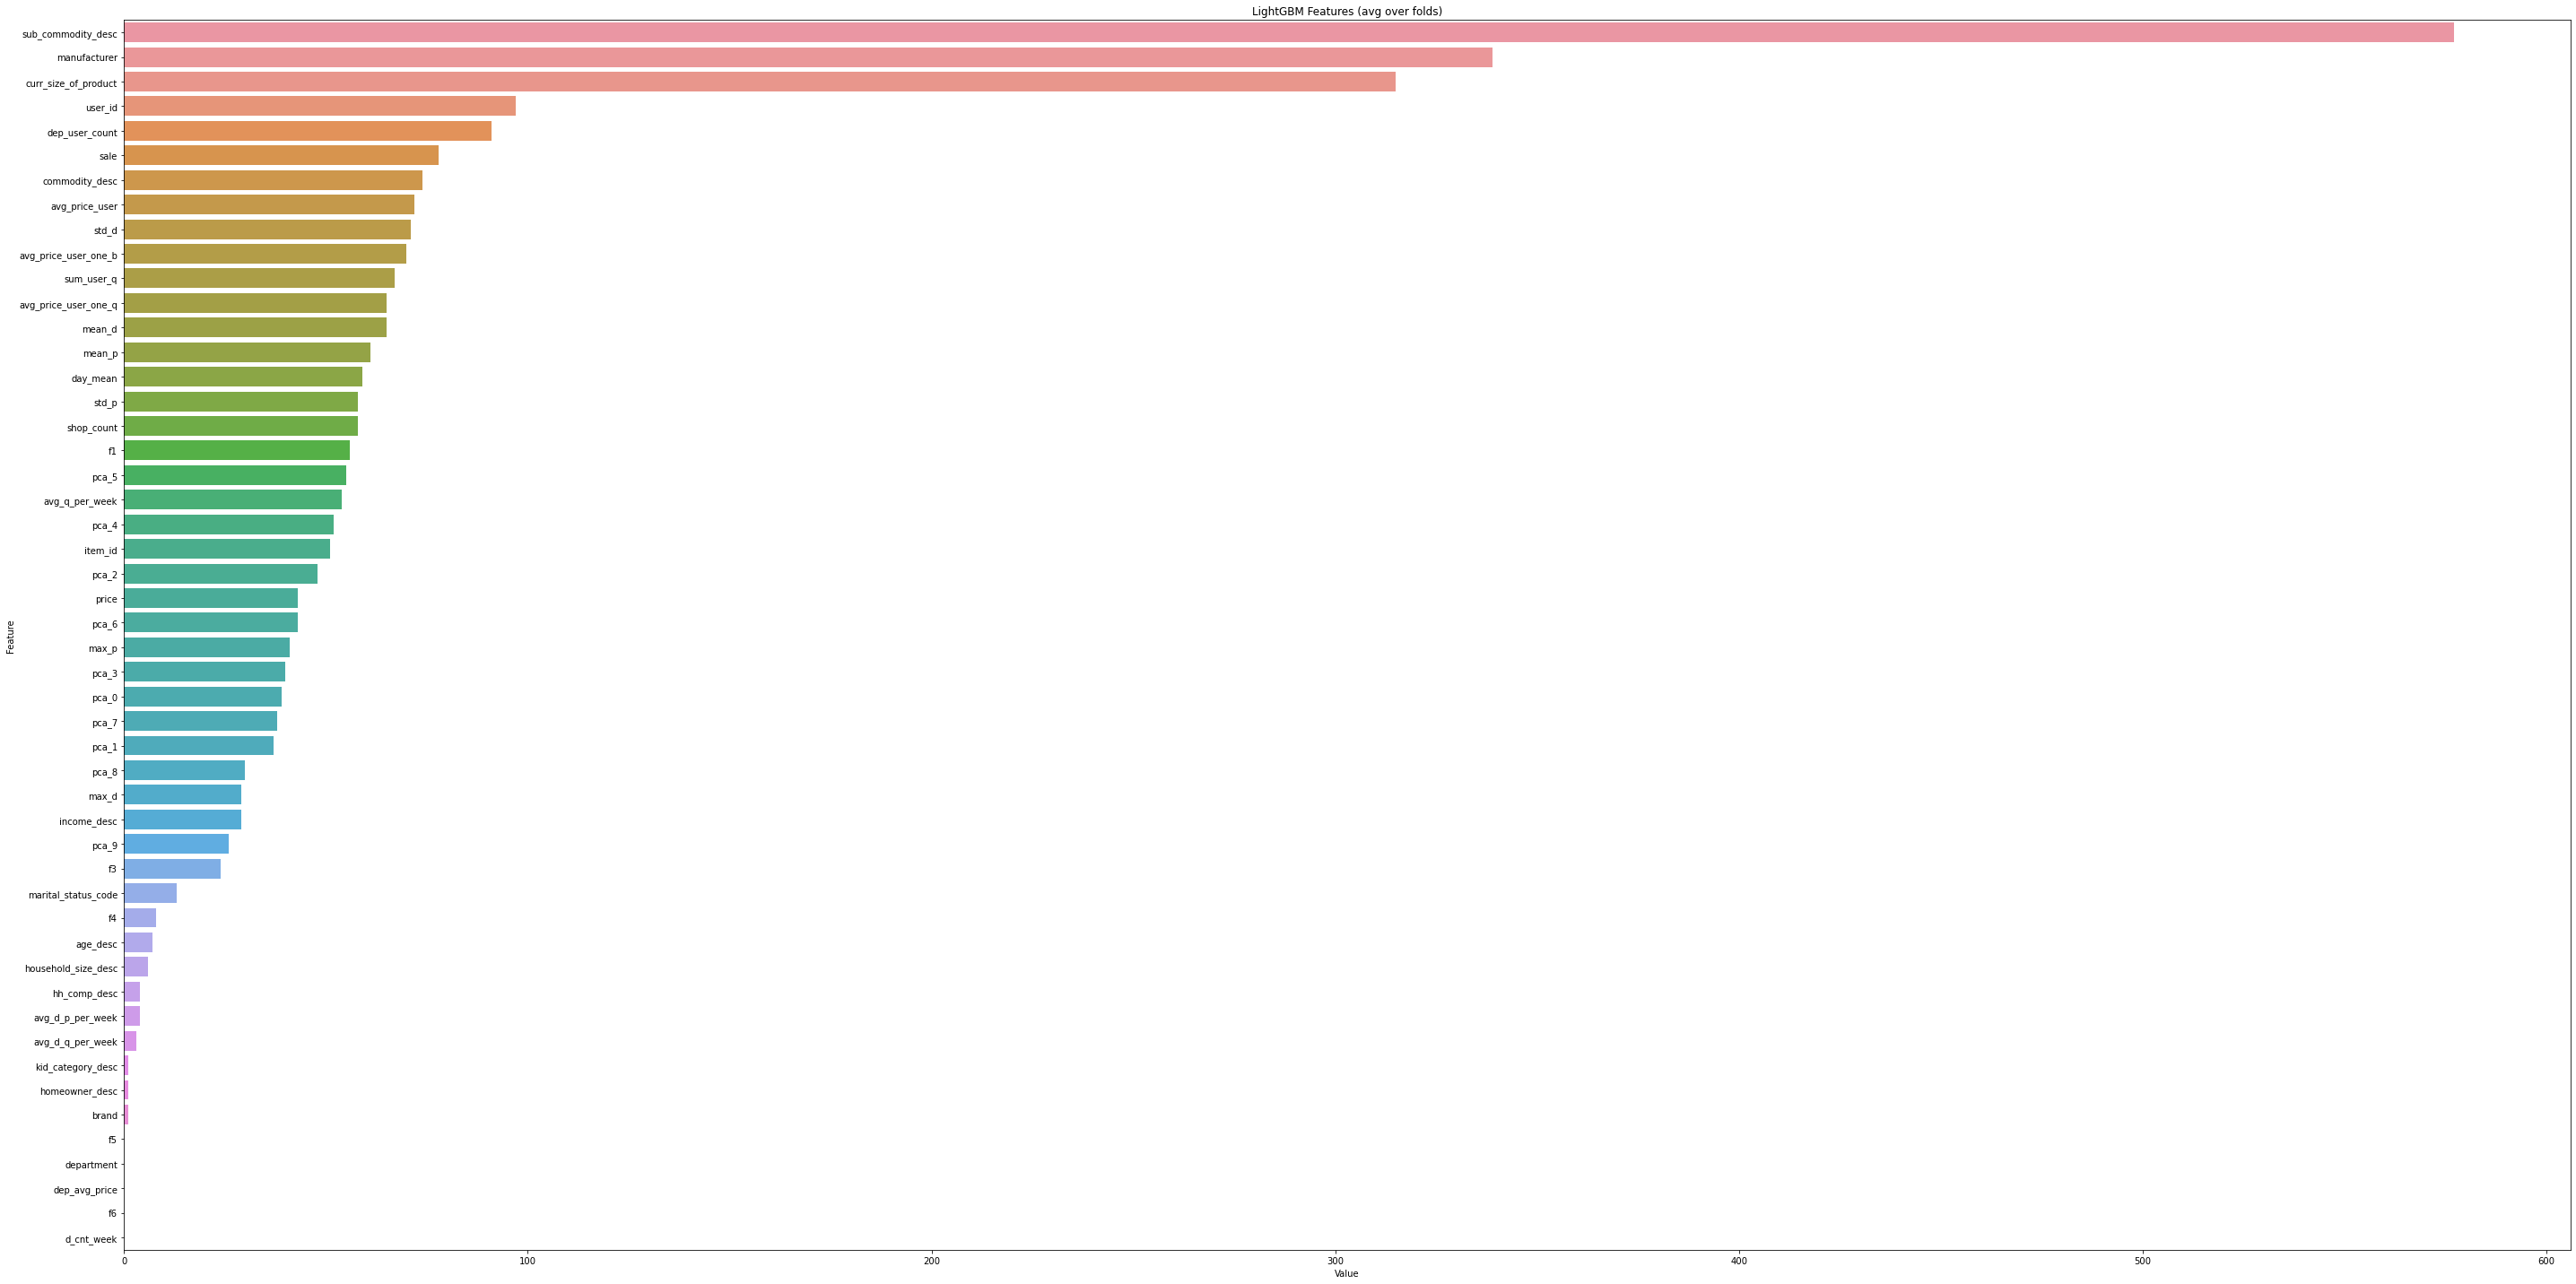

26.925273679200295


<Figure size 432x288 with 0 Axes>

In [78]:
user_item_matrix = pd.pivot_table(data_train_lvl_2,
                                          index='user_id', columns='item_id',
                                          values='quantity',
                                          aggfunc='sum',
                                          fill_value=0
                                         )
n=10
pca = PCA(n_components=n)
columns = ['pca_%i' % i for i in range(n)]
df_pca = pd.DataFrame(pca.fit_transform(user_item_matrix), columns=columns, index=user_item_matrix.index)
targets_lvl_2 = targets_lvl_2.merge(df_pca, on='user_id', how='left')
prec_at_5 = get_precision_lvl_2(targets_lvl_2, result_lvl_2, model_name, feat_imp_graph=True)
print(prec_at_5*100)